In [15]:
# Import necessary library
import pandas as pd

# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Reload the data from the Excel file
data = pd.read_excel("FS_BLOOM_V1 copy.xlsx")

# 1. Remove the unnecessary column
data_cleaned = data.drop(columns=['Unnamed: 0'])

# 2. Remove rows with NaN or '-' values
data_cleaned = data_cleaned.dropna(how='any')  # Remove rows with NaN values
data_cleaned = data_cleaned[~data_cleaned.isin(['—']).any(axis=1)]  # Remove rows with '-' values

# 3. Remove the 'MSCI Rating' column
data_cleaned = data_cleaned.drop(columns=['MSCI Rating'])

# Save the cleaned data to CSV in the root directory
file_path = 'cleaned_data.csv'
data_cleaned.to_csv(file_path, index=False)



Saving FS_BLOOM_V1 copy.xlsx to FS_BLOOM_V1 copy (1).xlsx


In [7]:
from google.colab import files
files.download('cleaned_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
def time_based_split(data):
    """
    Split the data based on the 'Year' column for each company.
    For each company, all years except the last one will be used for training.
    The last year will be used for validation/testing.
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()

    # Unique companies in the dataset
    companies = data['Name'].unique()

    for company in companies:
        company_data = data[data['Name'] == company]
        # If there's only one year's data for a company, it'll be used for training
        if len(company_data) == 1:
            train_data = pd.concat([train_data, company_data])
        else:
            # All years except the last one will be used for training
            train_data = pd.concat([train_data, company_data[:-1]])
            valid_data = pd.concat([valid_data, company_data[-1:]])

    return train_data, valid_data

# Apply the time_based_split function on the cleaned dataframe
train_data, valid_data = time_based_split(data_cleaned)

train_data.shape, valid_data.shape


((5250, 15), (1785, 15))

In [17]:
# Features to consider
features = [
    'ENVIRON_DISCLOSURE_SCORE',
    'SOCIAL_DISCLOSURE_SCORE',
    'GOVNCE_DISCLOSURE_SCORE',
    'ESG_DISCLOSURE_SCORE',
    'EBITDA'
]

In [18]:
# Importing necessary libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 1. Data Preparation

# Extract features and target from training data
X_train = train_data[features].values
y_train = train_data['EBITDA'].values

# Scale features and target data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Convert to supervised learning problem
def create_dataset(X, y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        dataX.append(X[i:(i + look_back), :])
        dataY.append(y[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
X_train_reshaped, y_train_reshaped = create_dataset(X_train_scaled, y_train_scaled, look_back)

# 2. Model Building & Training

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=100, batch_size=32, verbose=2, validation_split=0.2)

# Print the final training loss
print("Final training loss:", history.history['loss'][-1])


Epoch 1/100
132/132 - 3s - loss: 0.0056 - val_loss: 0.0034 - 3s/epoch - 22ms/step
Epoch 2/100
132/132 - 0s - loss: 0.0037 - val_loss: 0.0028 - 332ms/epoch - 3ms/step
Epoch 3/100
132/132 - 0s - loss: 0.0031 - val_loss: 0.0024 - 340ms/epoch - 3ms/step
Epoch 4/100
132/132 - 0s - loss: 0.0028 - val_loss: 0.0023 - 360ms/epoch - 3ms/step
Epoch 5/100
132/132 - 0s - loss: 0.0028 - val_loss: 0.0023 - 357ms/epoch - 3ms/step
Epoch 6/100
132/132 - 0s - loss: 0.0027 - val_loss: 0.0023 - 349ms/epoch - 3ms/step
Epoch 7/100
132/132 - 0s - loss: 0.0027 - val_loss: 0.0023 - 379ms/epoch - 3ms/step
Epoch 8/100
132/132 - 0s - loss: 0.0027 - val_loss: 0.0024 - 352ms/epoch - 3ms/step
Epoch 9/100
132/132 - 0s - loss: 0.0027 - val_loss: 0.0023 - 349ms/epoch - 3ms/step
Epoch 10/100
132/132 - 0s - loss: 0.0027 - val_loss: 0.0024 - 330ms/epoch - 3ms/step
Epoch 11/100
132/132 - 0s - loss: 0.0026 - val_loss: 0.0023 - 345ms/epoch - 3ms/step
Epoch 12/100
132/132 - 0s - loss: 0.0027 - val_loss: 0.0023 - 363ms/epoch - 

In [14]:
# # Build a more complex LSTM model
# model_complex = Sequential()

# # First LSTM layer with dropout
# model_complex.add(LSTM(100, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
# model_complex.add(Dropout(0.3))

# # Second LSTM layer with dropout
# model_complex.add(LSTM(100, return_sequences=True))
# model_complex.add(Dropout(0.3))

# # Third LSTM layer with dropout
# model_complex.add(LSTM(50))
# model_complex.add(Dropout(0.3))

# # Dense layer
# model_complex.add(Dense(50, activation='relu'))
# model_complex.add(Dropout(0.3))

# # Output layer
# model_complex.add(Dense(1))

# # Compile the model
# model_complex.compile(loss='mean_squared_error', optimizer='adam')

# # Train the model
# history_complex = model_complex.fit(X_train_reshaped, y_train_reshaped, epochs=100, batch_size=32, verbose=2, validation_split=0.2)

# # Print the final training loss for the complex model
# final_loss_complex = history_complex.history['loss'][-1]
# final_loss_complex


Saving the trained model

In [5]:
pip install h5py


In [20]:
# Assuming `model` is your trained Keras model

# Save the model to HDF5 file
model.save('LSTM_model_02.h5')

# Later on, you can load the model using:
from tensorflow.keras.models import load_model
loaded_model = load_model('LSTM_model_02.h5')


In [21]:
from google.colab import files

# Save the model to HDF5 file
model.save('LSTM_model_02.h5')

# Download the file to your local machine
files.download('LSTM_model_02.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
/content/drive/MyDrive/BD-CW

In [22]:
from google.colab import drive
drive.mount('/content/drive')

# After mounting, specify the path in Google Drive
path_to_model = '/content/drive/MyDrive/ColabNotebooks/LSTM_model_02.h5'

# Save the model to the path
model.save(path_to_model)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from tensorflow.keras.models import load_model

# Load the model from the HDF5 file
loaded_model = load_model('/content/drive/MyDrive/ColabNotebooks/LSTM_model_02.h5')

# Now you can use loaded_model to make predictions or continue training


In [24]:
# First we define the features and target as per the previous training setup
features = [
    'ENVIRON_DISCLOSURE_SCORE',
    'SOCIAL_DISCLOSURE_SCORE',
    'GOVNCE_DISCLOSURE_SCORE',
    'ESG_DISCLOSURE_SCORE',
    'EBITDA'
]

In [26]:
# After loading the model, check the model summary to confirm the expected input shape
model = load_model('LSTM_model_02.h5')  # Make sure to load the new, retrained model
model.summary()

# Ensure that the test data is reshaped according to the new input shape
# For example, if the new model expects 8 features, you would reshape your data like this:
# test_features_reshaped = test_features.reshape((test_features.shape[0], 1, 8))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Reload the data from the Excel file
test_data = pd.read_csv("FAME_ESG_Cleaned.csv")


# Assuming the preprocessing has already been done and the data is in the correct format
# Extract features and target from the test data if needed
test_features = test_data[features].values
test_target = test_data['EBITDA'].values  # If EBITDA is what you want to predict

# Load the trained model
model = load_model('LSTM_model_02.h5')

# Assuming test_features is a 2D numpy array with shape (num_samples, 5)
# We need to add a time step dimension to match the expected input shape (None, 1, 5)
test_features_reshaped = np.expand_dims(test_features, axis=1)

# Make predictions with the model
predictions = model.predict(test_features_reshaped)


# If you have scaled your target variable during training, you need to inverse the scaling
# to interpret the predictions. Assuming 'scaler_y' is your target variable scaler:
predictions_inversed = scaler_y.inverse_transform(predictions)


Saving FAME_ESG_Cleaned.csv to FAME_ESG_Cleaned (4).csv
17/17 [==============================] - 0s 1ms/step


In [30]:
test_data.head()

Number of employees\nLast avail. yr  Year   EBITDA  \
Company name                                                              
ABEL & COLE LIMITED                                  687  2022   5127.0   
ABEL & COLE LIMITED                                  687  2021  12628.0   
ABEL & COLE LIMITED                                  687  2020   3012.0   
ABEL & COLE LIMITED                                  687  2019   -506.0   
ABEL & COLE LIMITED                                  687  2018   1537.0   

                     ESG_DISCLOSURE_SCORE  SOCIAL_DISCLOSURE_SCORE  \
Company name                                                         
ABEL & COLE LIMITED                 103.5                     52.8   
ABEL & COLE LIMITED                 103.5                     52.8   
ABEL & COLE LIMITED                 103.5                     52.8   
ABEL & COLE LIMITED                 103.5                     52.8   
ABEL & COLE LIMITED                 103.5                     52.8   

                     ENVIRON_DISCLOSURE_SCORE  GOVNCE_DISCLOSURE_SCORE  
Company name                                                            
ABEL & COLE LIMITED                      36.1                     14.6  
ABEL & COLE LIMITED                      36.1                     14.6  
ABEL & COLE LIMITED                      36.1                     14.6  
ABEL & COLE LIMITED                      36.1                     14.6  
ABEL & COLE LIMITED                      36.1                     14.6

In [31]:
print(test_data.columns)


Index(['Number of employees\nLast avail. yr', 'Year', 'EBITDA',
       'ESG_DISCLOSURE_SCORE', 'SOCIAL_DISCLOSURE_SCORE',
       'ENVIRON_DISCLOSURE_SCORE', 'GOVNCE_DISCLOSURE_SCORE'],
      dtype='object')


Mean Squared Error: 2633207358.4243655
Root Mean Squared Error: 51314.78693733772


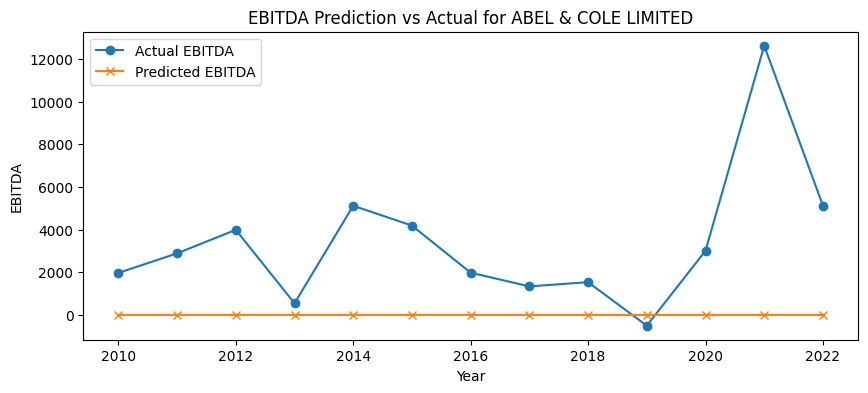

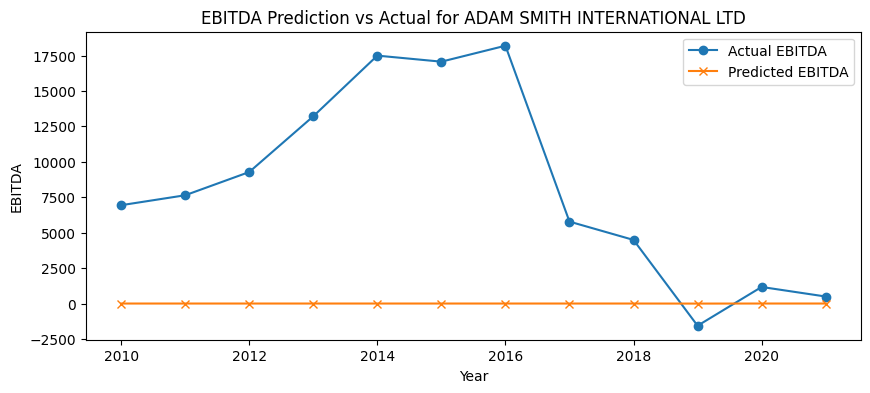

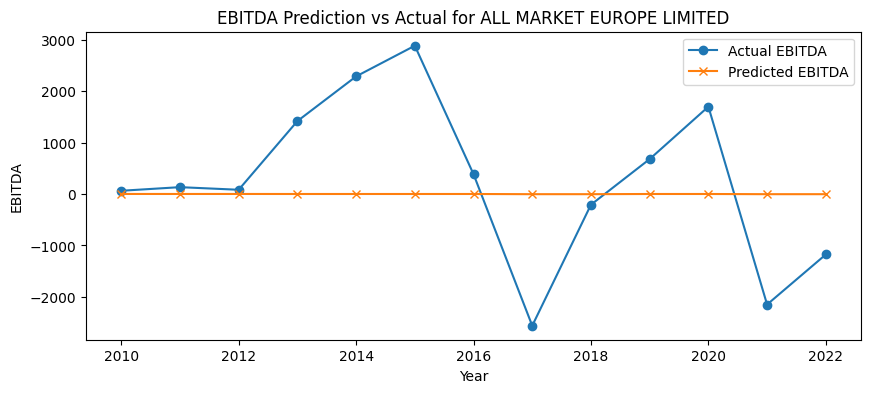

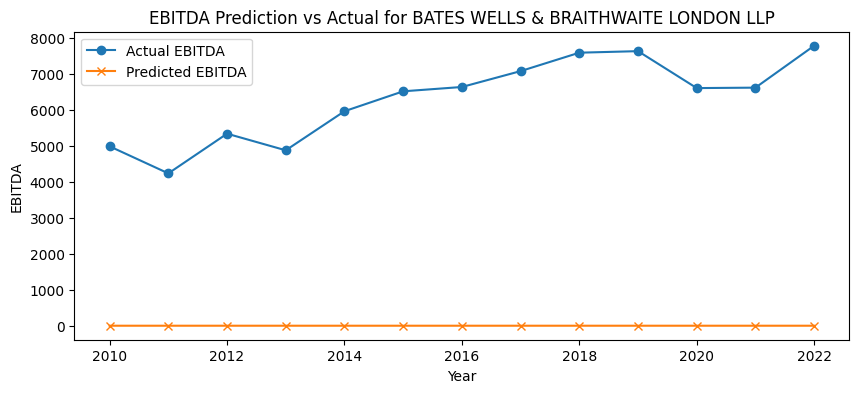

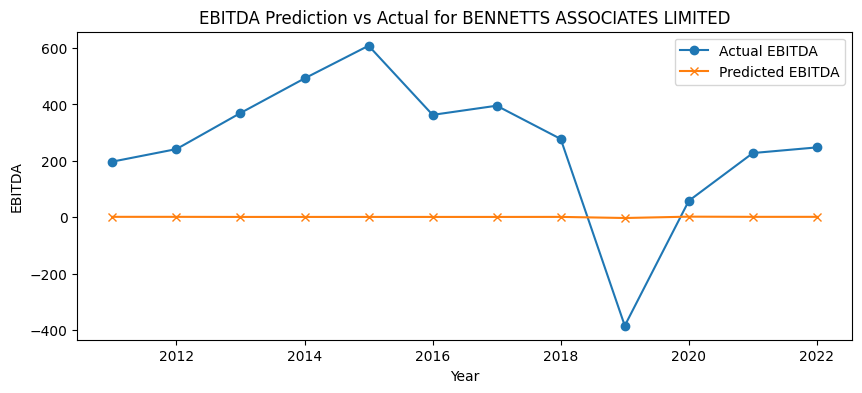

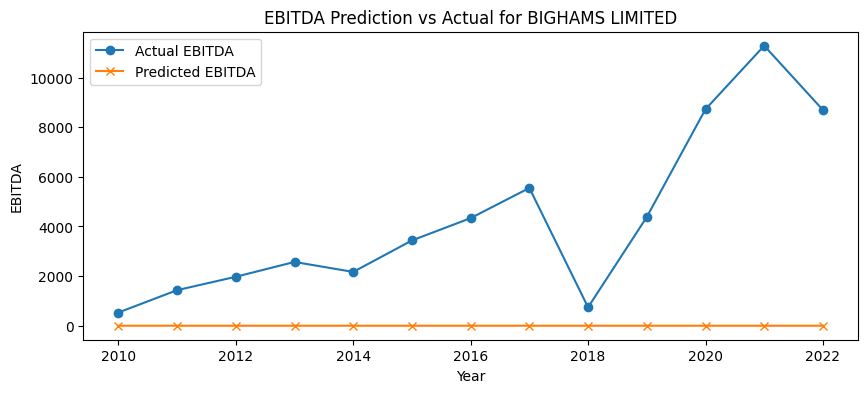

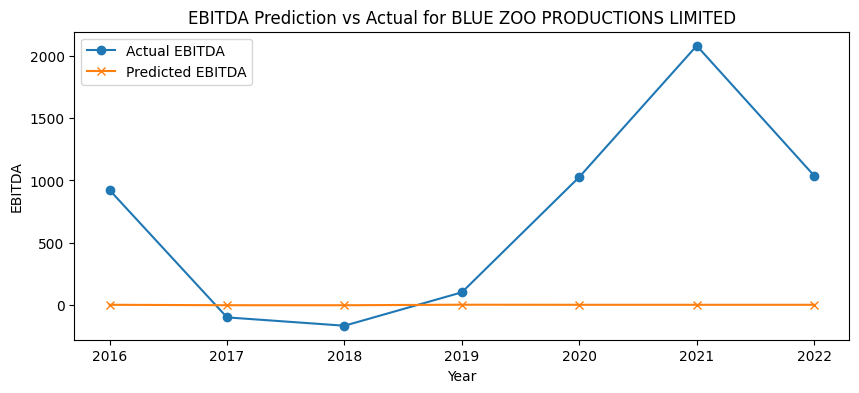

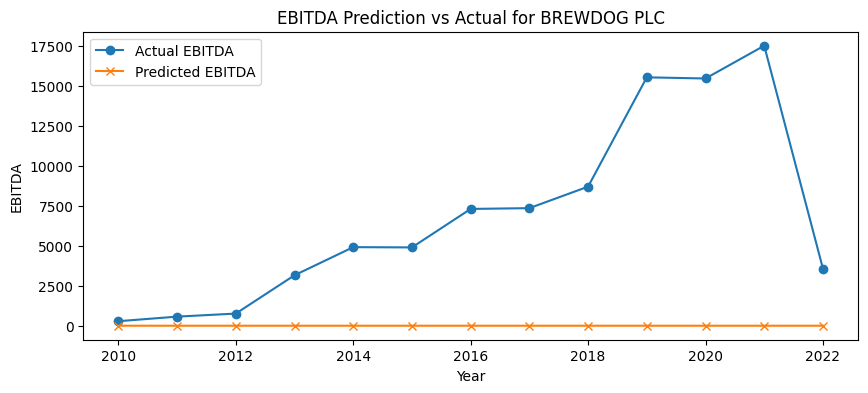

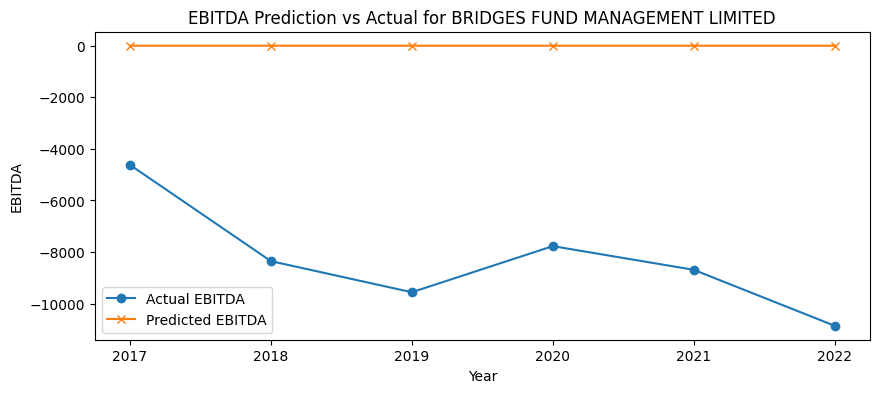

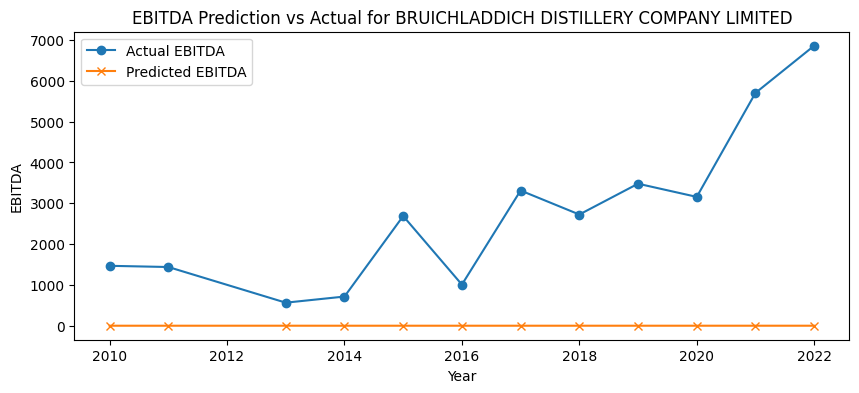

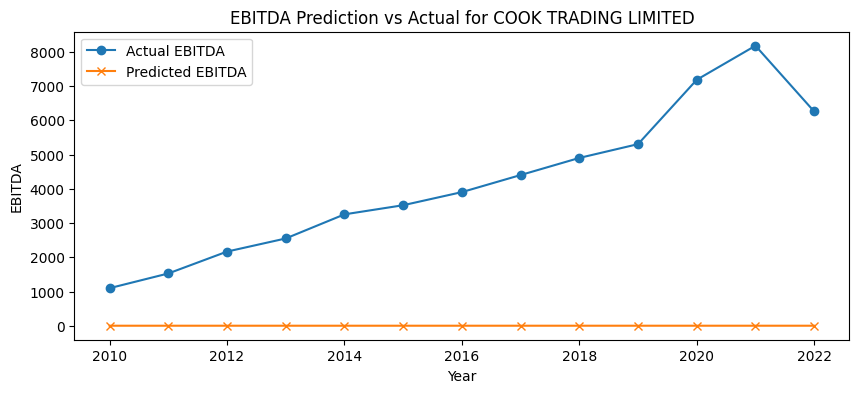

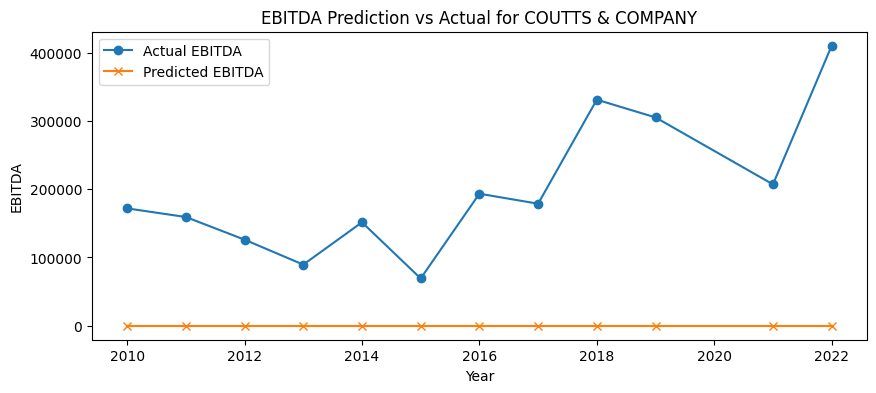

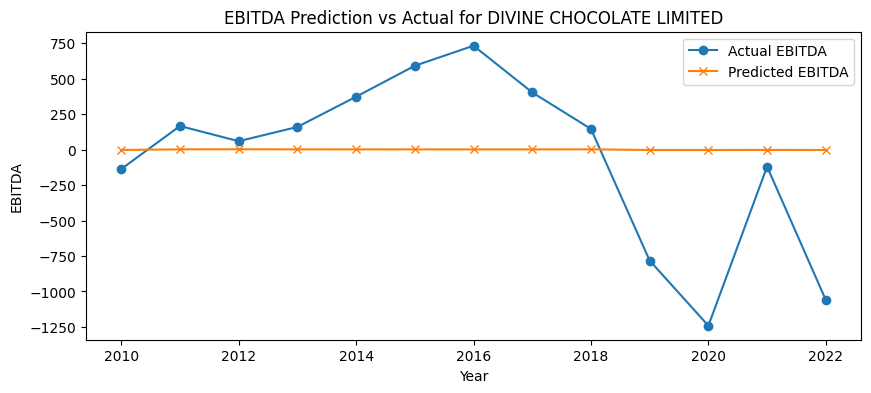

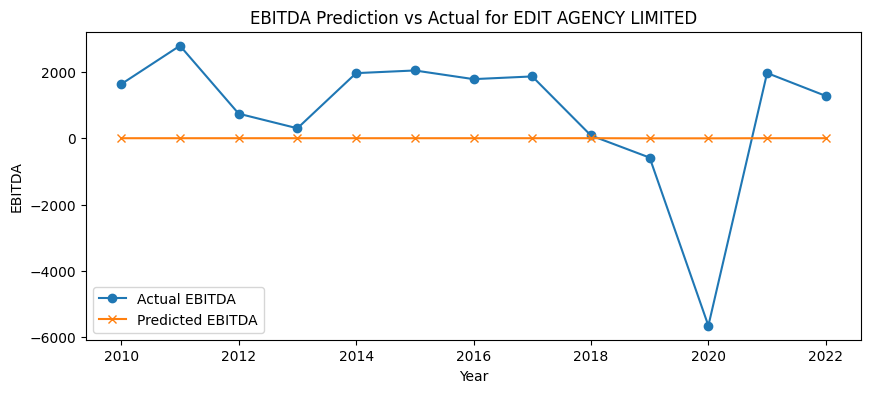

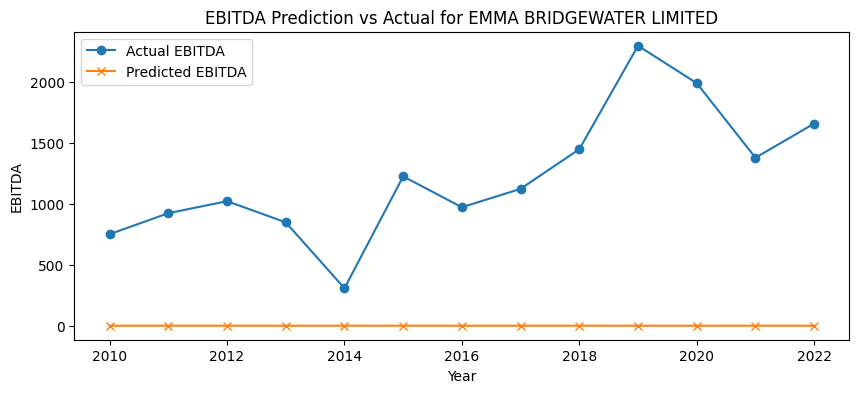

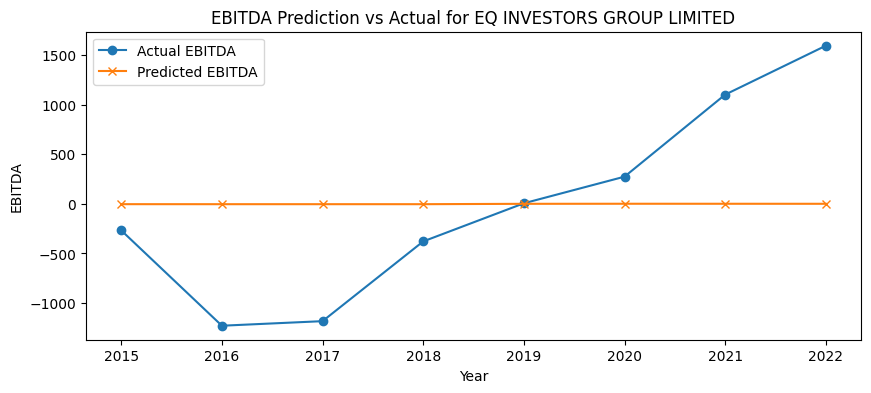

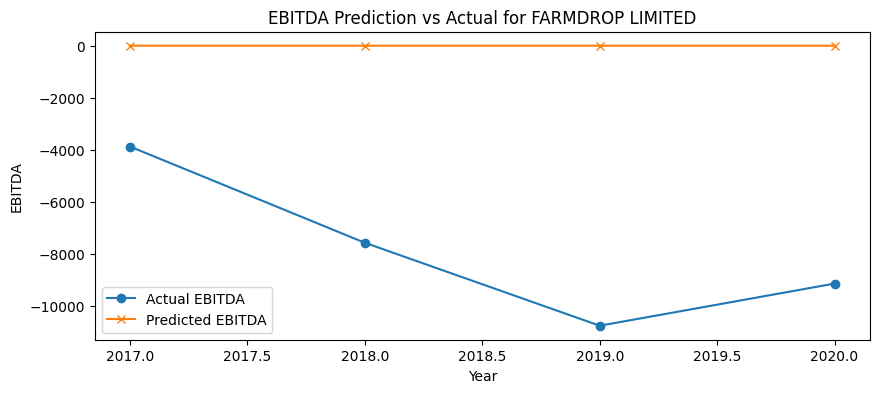

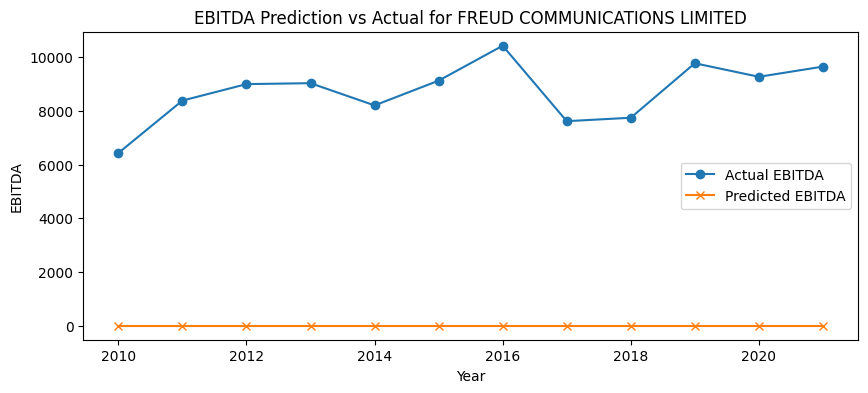

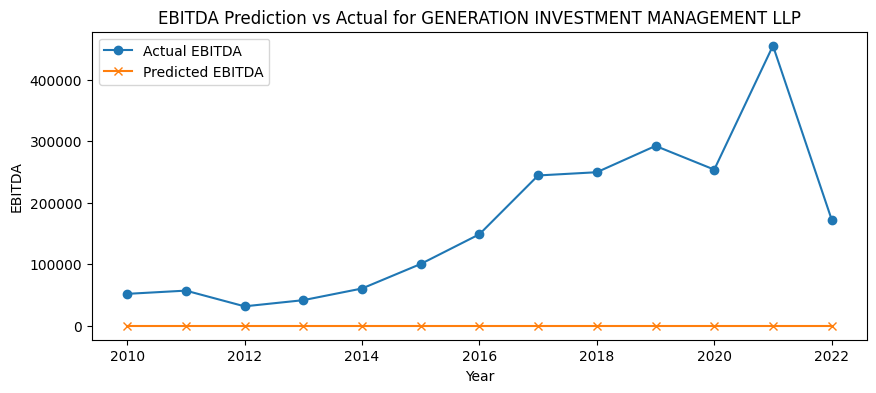

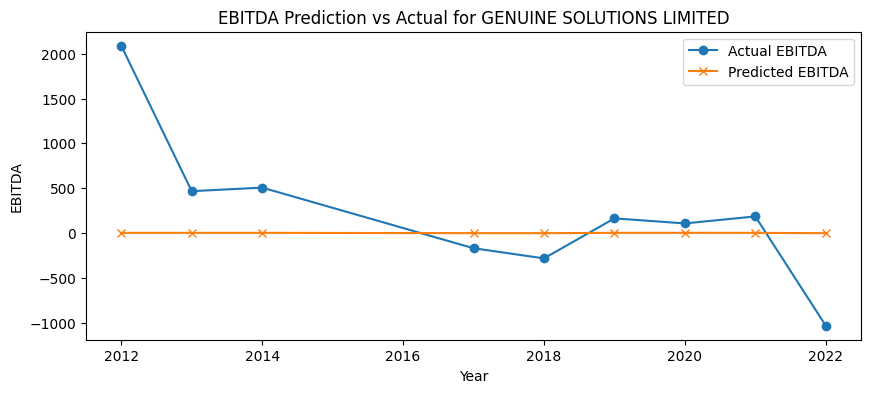

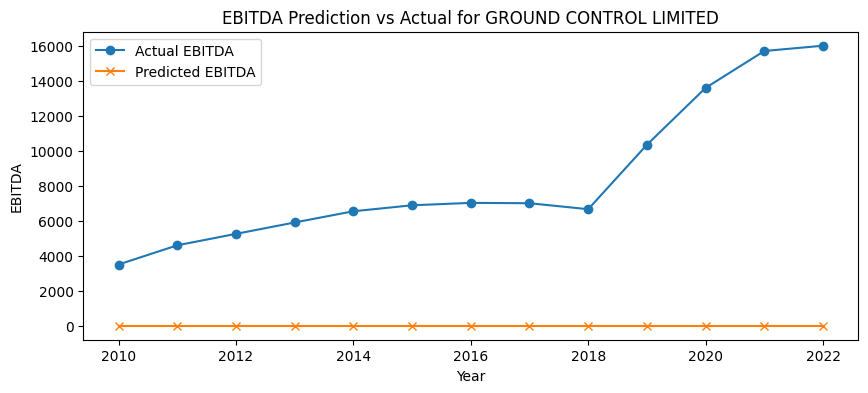

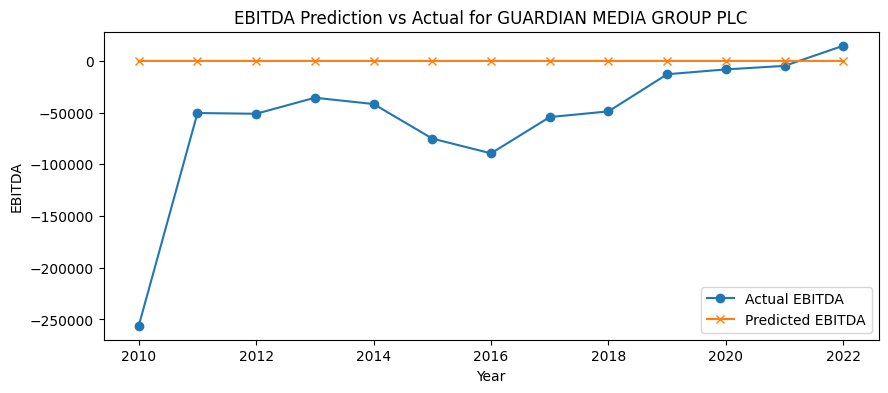

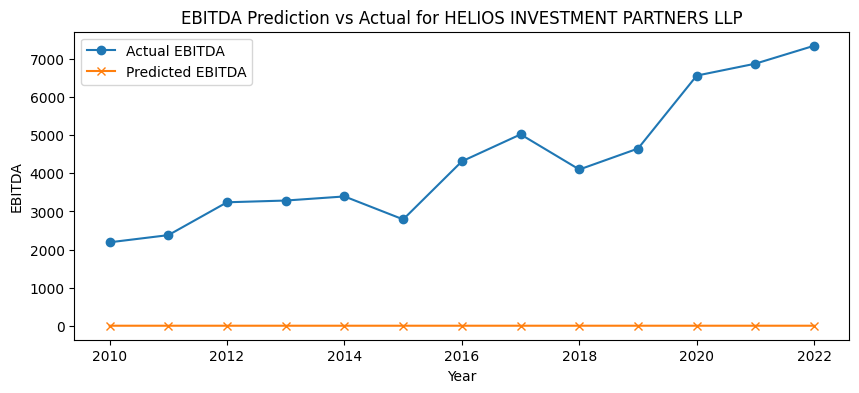

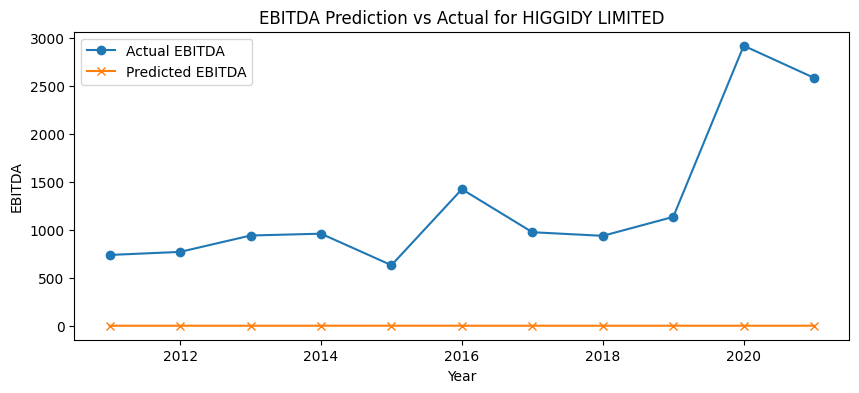

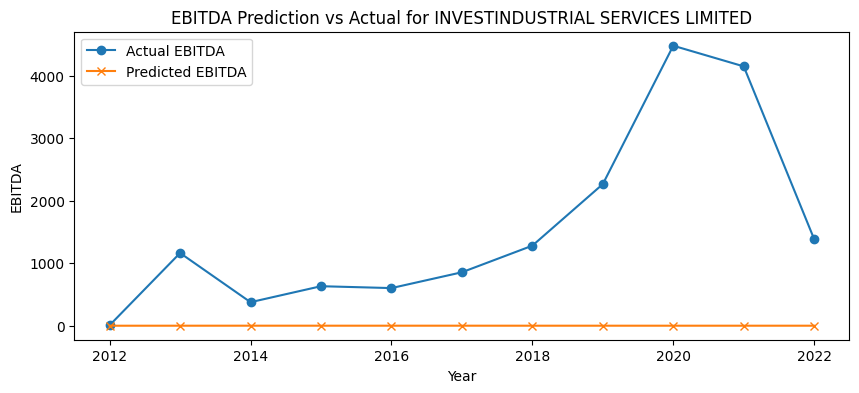

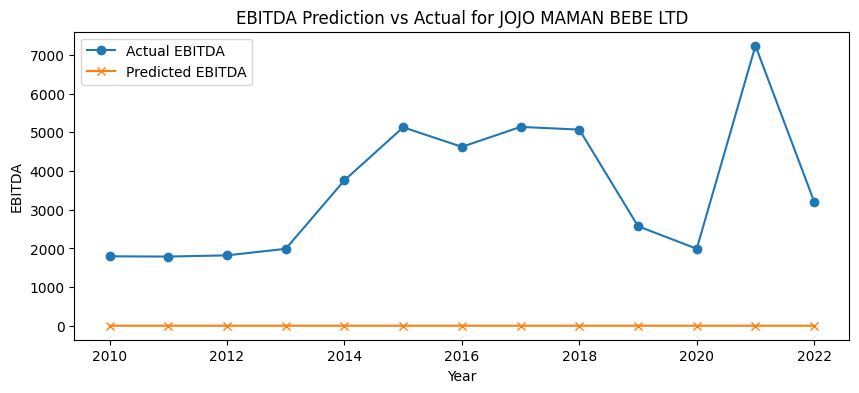

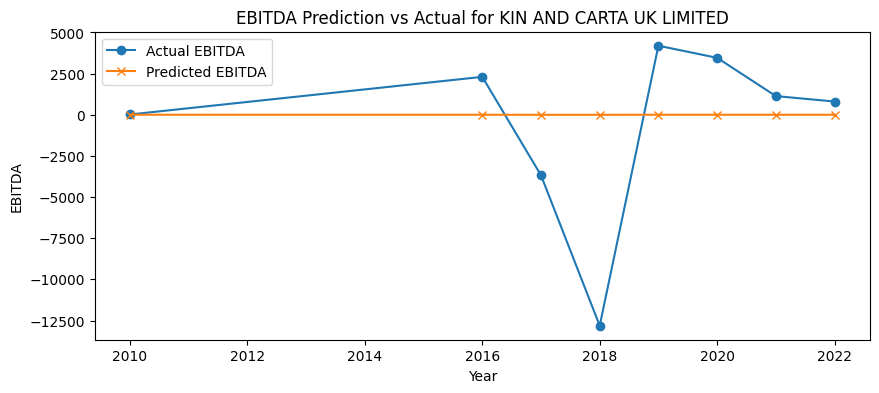

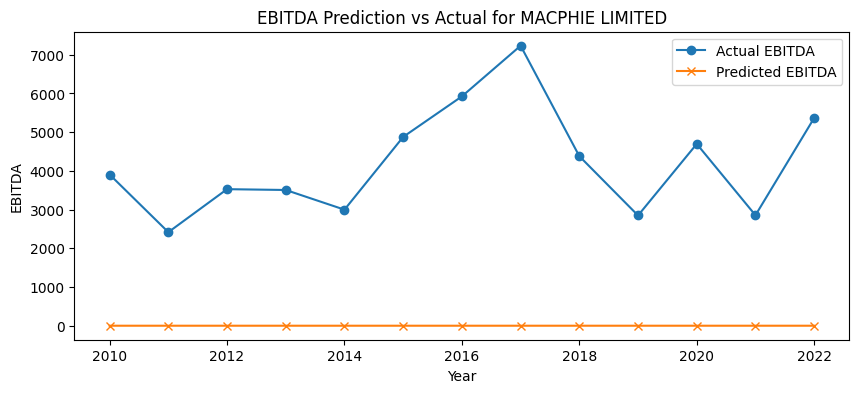

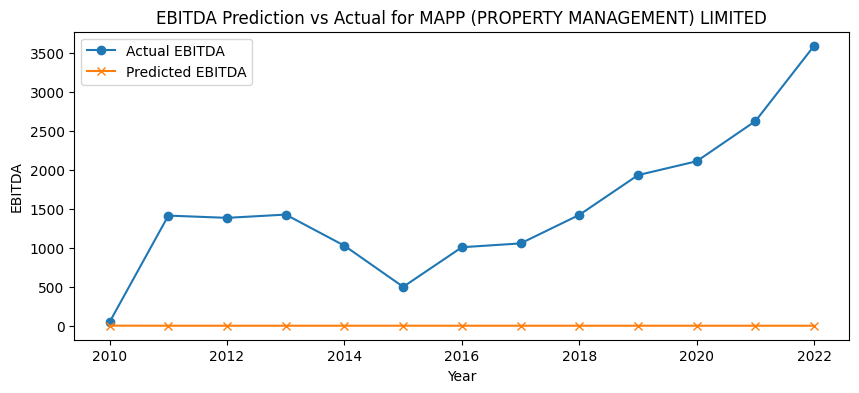

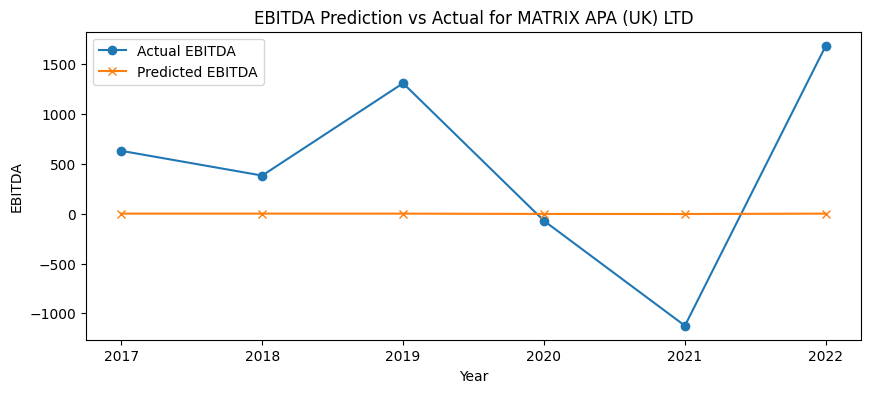

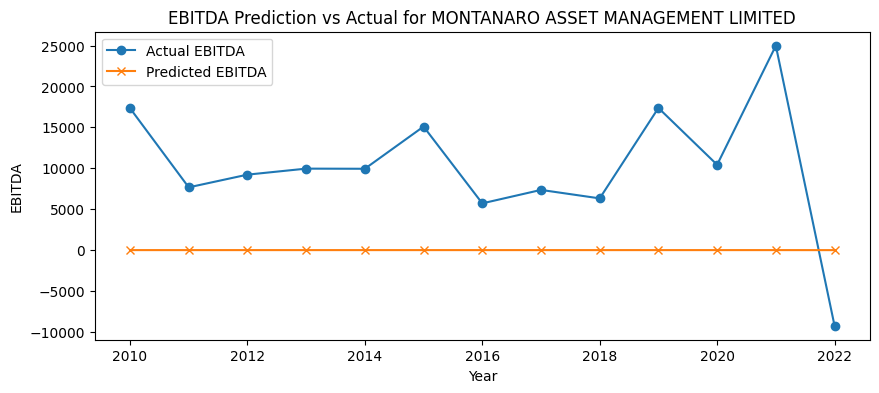

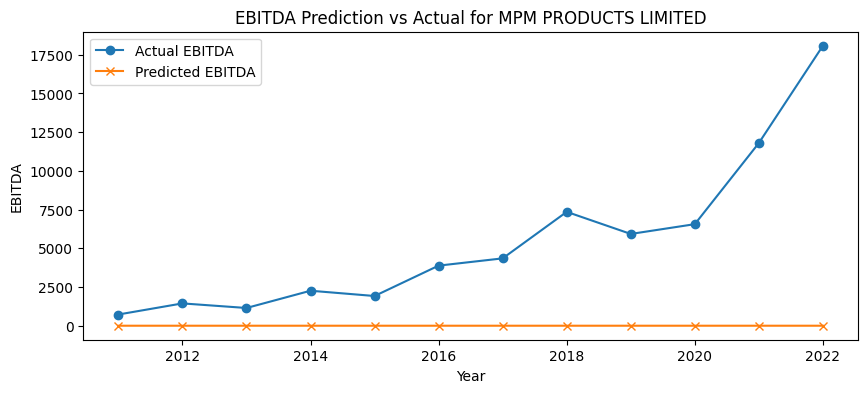

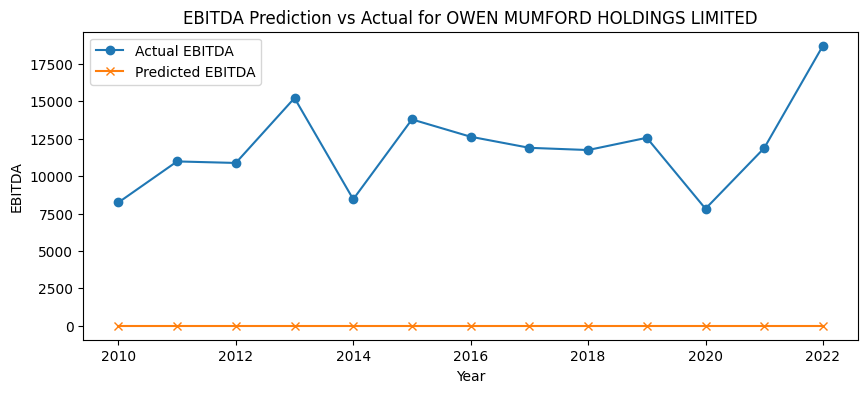

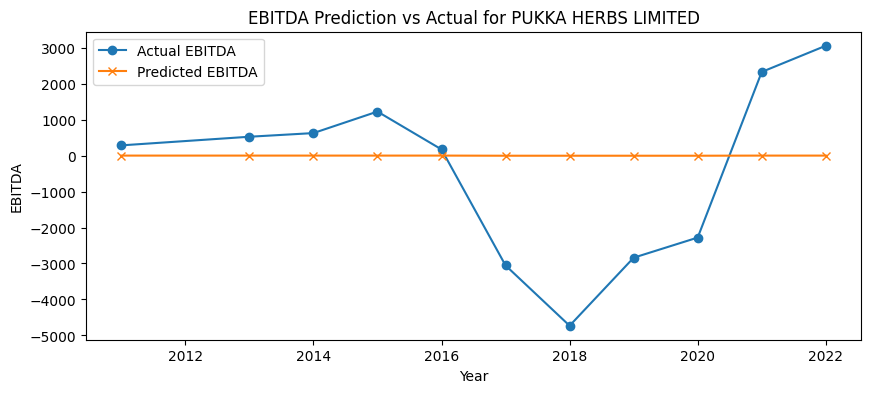

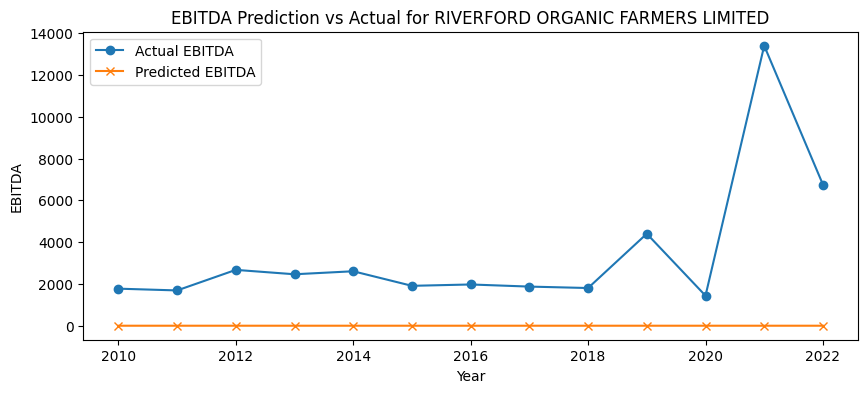

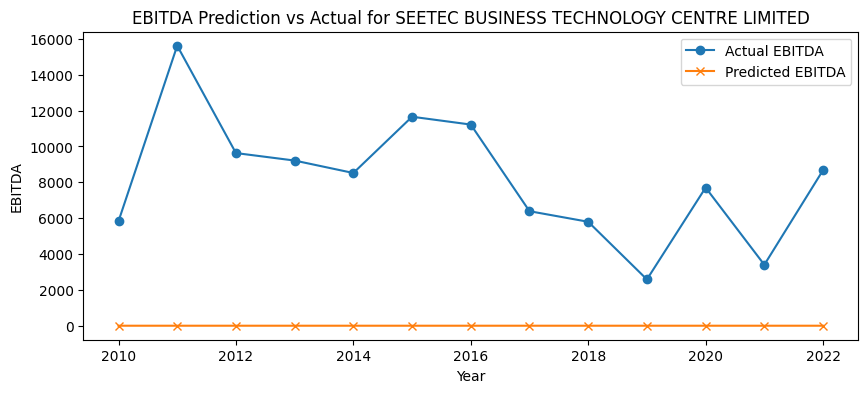

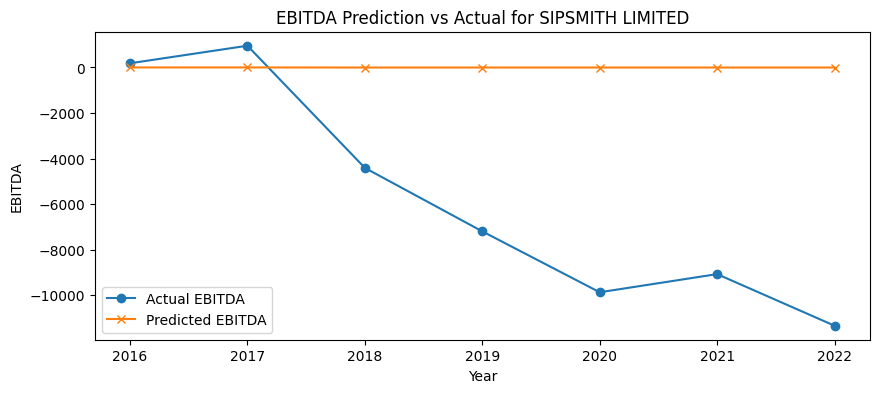

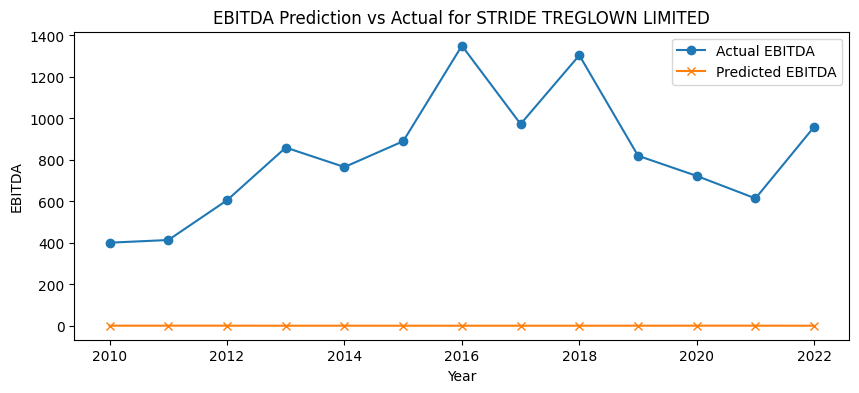

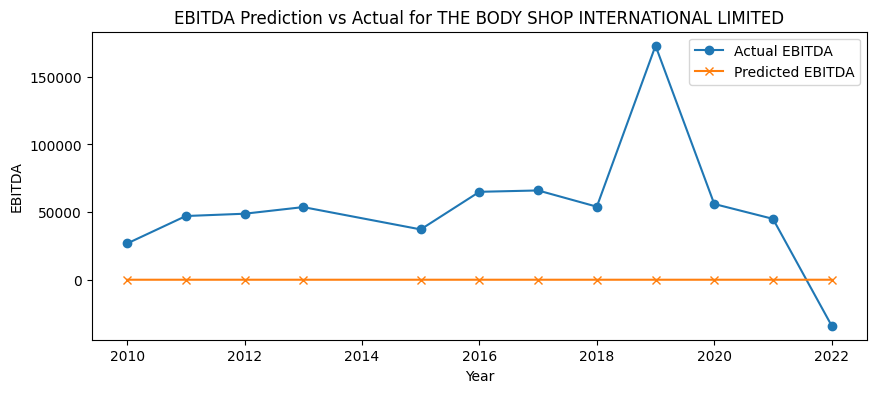

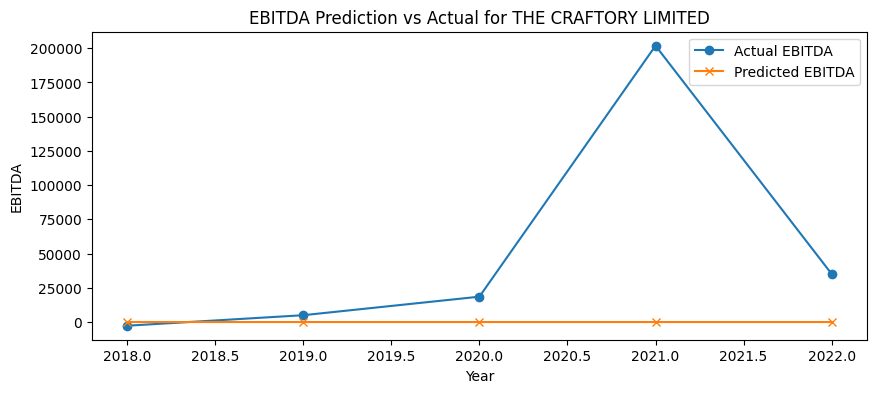

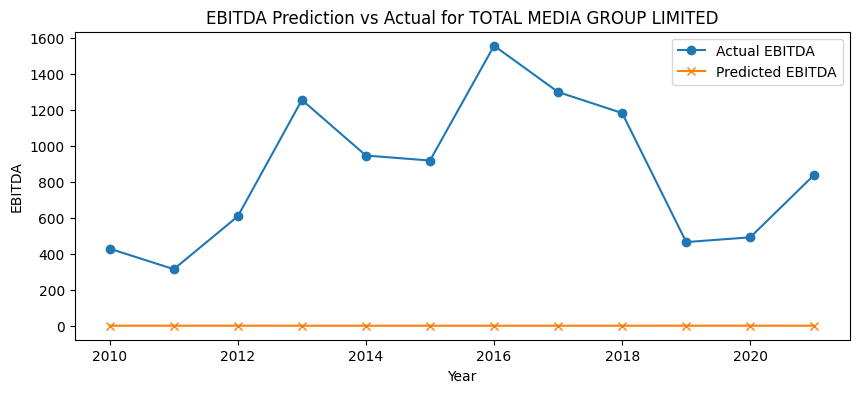

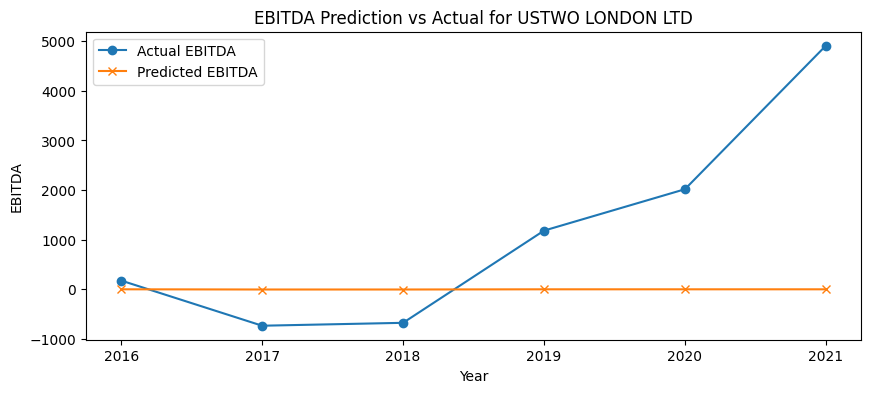

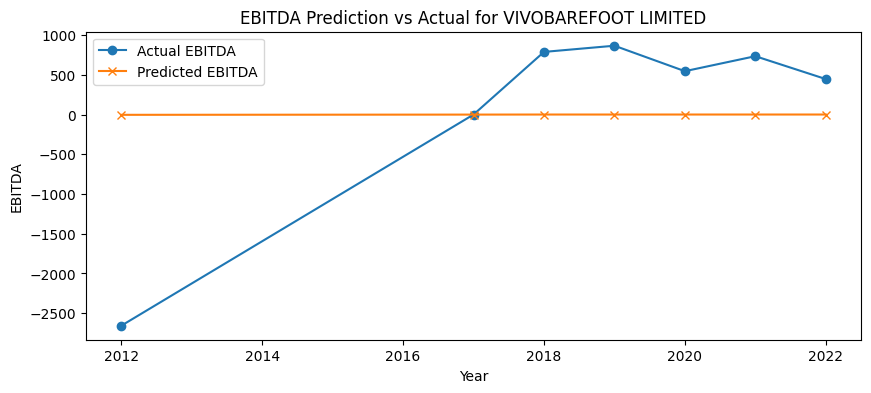

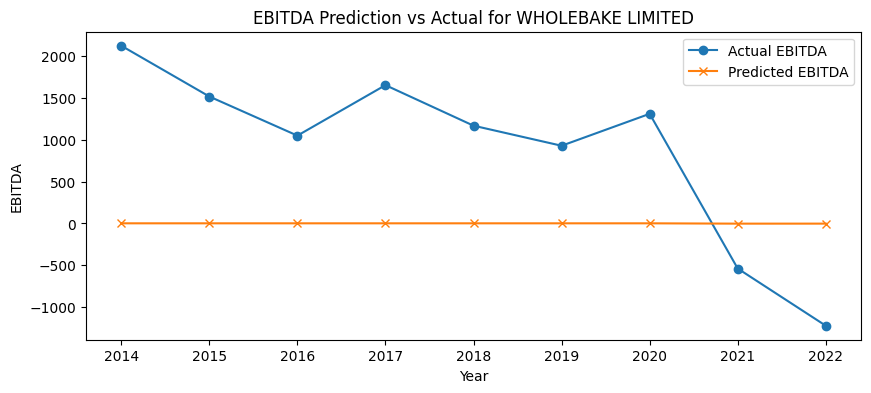

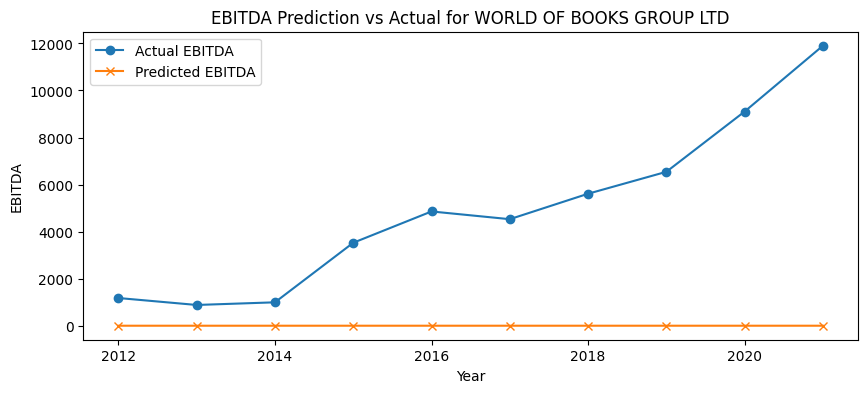

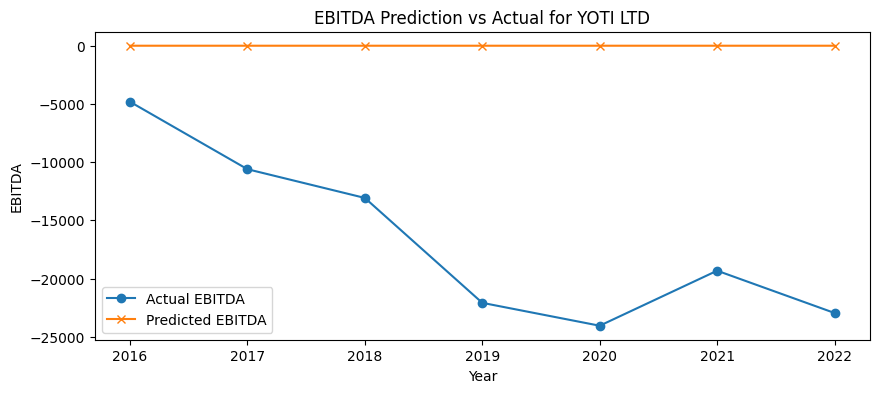

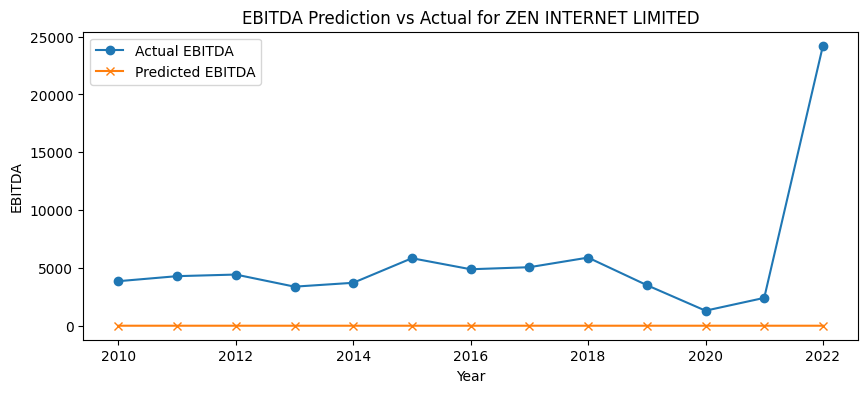

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Reset the index to turn the 'Company name' into a column
test_data.reset_index(inplace=True)

# Assuming 'predictions' is a numpy array with your predicted EBITDA values
test_data['Predicted_EBITDA'] = predictions.flatten()  # Flatten in case predictions have an extra dimension

# Calculate the metrics
mse = mean_squared_error(test_data['EBITDA'], test_data['Predicted_EBITDA'])
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Now, let's plot the actual vs. predicted EBITDA for each company
for company in test_data['Company name'].unique():
    plt.figure(figsize=(10, 4))
    plt.title(f'EBITDA Prediction vs Actual for {company}')

    company_data = test_data[test_data['Company name'] == company]
    plt.plot(company_data['Year'], company_data['EBITDA'], label='Actual EBITDA', marker='o')
    plt.plot(company_data['Year'], company_data['Predicted_EBITDA'], label='Predicted EBITDA', marker='x')

    plt.xlabel('Year')
    plt.ylabel('EBITDA')
    plt.legend()
    plt.show()
